# Explanations using Naive Bayes Model

Notebook to illustrate the principle of using an additive model to generate explanations for binary outcomes.

As a reminder, our goal is to *explain* an observed outcome. We do so by identifying a set of causal factors and the task of the model is to produce a rank-ordering of those factors by their causal contribution to the event.

## Sample Data (Random)
Randomly generated sample binomial data. Probability of "1" (Anomaly) is a function of X

In [33]:
# Generate data
import numpy as np

# Basic log-odds relationship
def logodds(x, ix=0, base_odds=1.0):
    if ix == 0:
        return 0.5 * x - 2.0 - np.log(base_odds)
    elif ix == 1:
        return 0.25 * x - 2.5 - np.log(base_odds)
    elif ix == 2:
        return -0.4 * x - 1.5 - np.log(base_odds)
    else:
        return 0.0

# Inverse function
def inv_logodds(y, ix=0, base_odds=1.0):
    if ix == 0:
        return (y + 2.0 + np.log(base_odds)) / 0.5
    elif ix == 1:
        return (y + 2.5 + np.log(base_odds)) / 0.25
    elif ix == 2:
        return (y + 1.5 + np.log(base_odds)) / -0.4
    else:
        return 0.0

# Generate 300 x values uniformly distributed between -5 and 5
x_values = np.random.uniform(-5, 5, 300)

# Calculate the probabilities for y using the logodds function
probabilities = 1 / (1 + np.exp(-logodds(x_values)))

# Generate y values as binomial (1 or -1) based on the calculated probabilities
y_values = np.random.binomial(1, probabilities) * 2 - 1

# Calculate base_odds as ratio of y=1 to y=-1
base_odds = np.mean(y_values == 1) / np.mean(y_values == -1)
print(f"Base Odds: {base_odds*100:.0f}:100")
# Combine x and y values into pairs
xy_pairs = list(zip(x_values, y_values))

Base Odds: 27:100


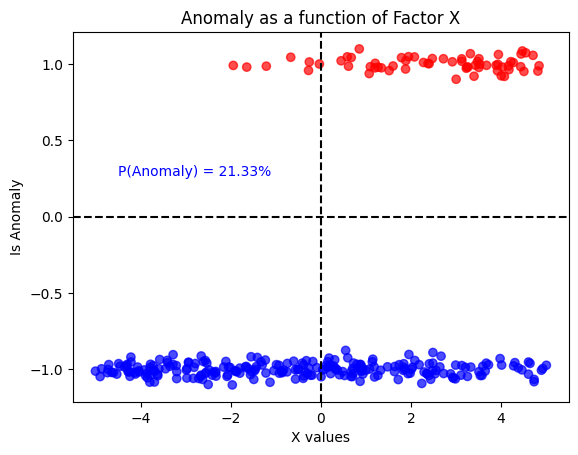

In [34]:
# Plot the data
import matplotlib.pyplot as plt

# Extract x and y values from xy_pairs
x_vals, y_vals = zip(*xy_pairs)

# Add small random noise to x and y values for dithering
x_vals_dithered = np.array(x_vals) + np.random.normal(0, 0.04, len(x_vals))
y_vals_dithered = np.array(y_vals) + np.random.normal(0, 0.04, len(y_vals))

# Create a scatter plot with dithered values
plt.scatter(x_vals_dithered, y_vals_dithered, c=y_vals, cmap='bwr', alpha=0.7)
plt.xlabel('X values')
plt.ylabel('Is Anomaly')
plt.title('Anomaly as a function of Factor X')
# plt.colorbar(label='Y values')
prob = 100* base_odds / (1 + base_odds)
plt.text(-4.5, 0.25, f"P(Anomaly) = {prob:.2f}%", color='blue', va='bottom', ha='left')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

plt.show()

In [35]:
# Define the bins
bins = np.linspace(-5, 5, 11)

# Initialize a list to store the odds
odds = []

# Loop through each bin range
for i in range(len(bins) - 1):
    # Get the x and y values that fall into the current bin
    bin_x_vals = [x for x in x_vals if bins[i] <= x < bins[i + 1]]
    bin_y_vals = [y for x, y in xy_pairs if bins[i] <= x < bins[i + 1]]
    
    # Calculate the count of y=1 and y=-1
    count_y1 = bin_y_vals.count(1)
    count_y_minus1 = bin_y_vals.count(-1)
    
    # Calculate the odds
    if count_y_minus1 == 0:
        odds.append(5)
    else:
        odds.append(count_y1 / count_y_minus1)


## Fit a Logistic Regression Model

### Measure the Odds as a function of X.
Odds is simply $o_1 = \frac{n_1}{n_0}$. Note relation to probability: $P(1) = \frac{o_1}{1+o_1}$

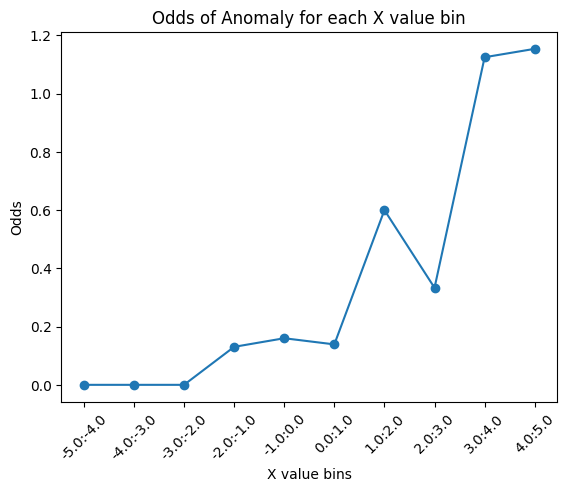

In [36]:
# Plot the binned result
# Calculate the center of each bin
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create x-y pairs with x being the center of the bin and y being the odds
xy_odds_pairs = list(zip(bin_centers, odds))

# Extract x and y values from xy_odds_pairs
x_vals_odds, y_vals_odds = zip(*xy_odds_pairs)

# Plot the result with lines-points and slanted x-labels
plt.plot(x_vals_odds, y_vals_odds, marker='o', linestyle='-')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.xlabel('X value bins')
plt.ylabel('Odds')
plt.title('Odds of Anomaly for each X value bin')
plt.show()

### Fit linear model to log(odds).
The problem with odds is that it isn't symmetrical. Solve by taking log. We then fit a line to the log(odds)


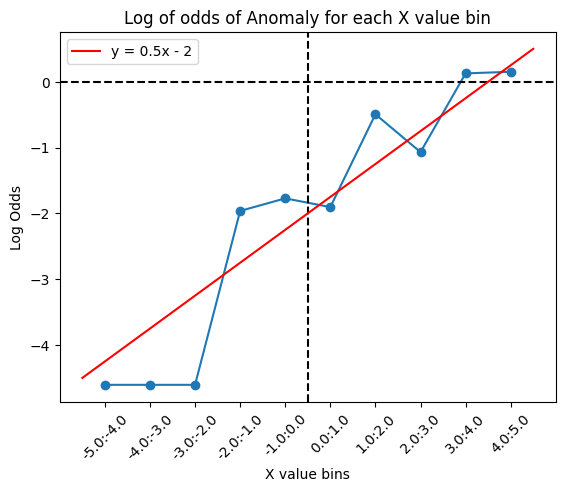

In [37]:
# Fit a line
# Extract x and y values from xy_odds_pairs
y_vals_logodds = np.log(np.array(y_vals_odds) + 0.01)

# Plot the result with lines-points and slanted x-labels
plt.plot(x_vals_odds, y_vals_logodds, marker='o', linestyle='-')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.xlabel('X value bins')
plt.ylabel('Log Odds')
plt.title('Log of odds of Anomaly for each X value bin')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Overlay the line y = 0.5x - 1
x_line = np.linspace(-5, 5, 100)
#y_line = 0.5 * x_line - 1
y_line = [logodds(x) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2')

plt.legend()
plt.show()

## Convert to Relative Odds
Since we are looking at multiple factors, it is useful to model odds relative to the base rate. We can easily do that by dividing odds as a function of a factor by the overall odds (in log space that means subtracting the base odds).

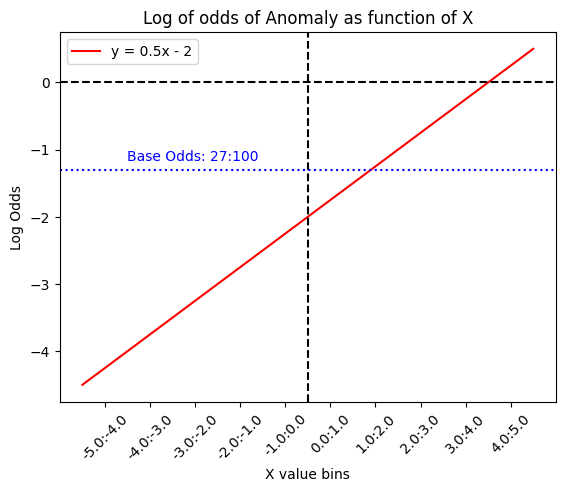

In [38]:
# Show the base odds
# Overlay the line y = 0.5x - 1
x_line = np.linspace(-5, 5, 100)
y_line = [logodds(x) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Add a dotted horizontal line at y=-2 with label "Base Odds"
plt.axhline(y=np.log(base_odds), color='blue', linestyle=':')
plt.text(-4, np.log(base_odds)+0.1, f'Base Odds: {base_odds*100:.0f}:100', color='blue', va='bottom', ha='left')

plt.xlabel('X value bins')
plt.ylabel('Log Odds')
plt.title('Log of odds of Anomaly as function of X')
plt.legend()
plt.show()

### Relative Odds Model
This leaves us with a useful measure of how any times more/less likely a factor made the observation of an anomaly.

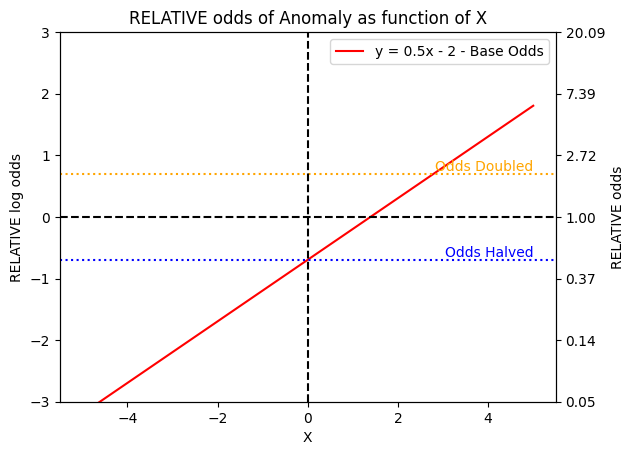

In [39]:
# Plot the relative odds
x_line = np.linspace(-5, 5, 100)
y_line = [logodds(x, base_odds=base_odds) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2 - Base Odds')

# Add a dotted horizontal line at y=-0.7 with label "Odds halved"
plt.axhline(y=-0.7, color='blue', linestyle=':')
plt.text(5, -0.7, 'Odds Halved', color='blue', va='bottom', ha='right')

# Add a dotted horizontal line at y=0.7 with label "Odds Doubled"
plt.axhline(y=0.7, color='orange', linestyle=':')
plt.text(5, 0.7, 'Odds Doubled', color='orange', va='bottom', ha='right')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Update y-tick labels to be exp(y)
yticks = ax.get_yticks()

# Fix the Y-limits to be -3 to 3
ax.set_ylim(-3, 3)



plt.legend()
plt.xlabel('X')
plt.ylabel('RELATIVE log odds')
plt.title('RELATIVE odds of Anomaly as function of X')

# Create a secondary Y-axis
ax2 = ax.twinx()
ax2.set_ylabel('RELATIVE odds')
ax2.set_ylim(-3, 3)
yticks = ax.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{np.exp(y):.2f}' for y in yticks])

plt.show()

## Assigning Explanations
We do this for a number of assumed independent factors.

In the graph below we have illustrated 3 hypothetical factors. For Ecolab, examples are *hours staffed*, *ratio of slow chicked orders*, *Drive-thru service time relative to average*, etc.

As above, the relative (log) odds of observing an anomaly is modeled as a linear relationship. For each of our analysis units (shifts), we observe actual values for these factors (black dots) which then map to relative odds of an anomalous KPI. 


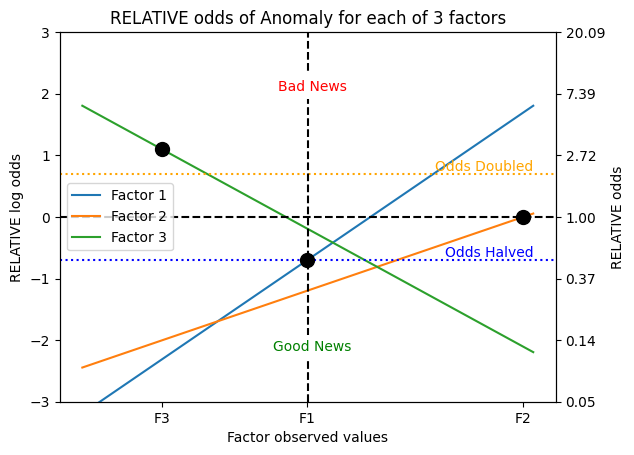

In [40]:
# Plot the lines for each log-odds function
x_line = np.linspace(-5, 5, 100)
for i in range(3):
    y_line = [logodds(x, i, base_odds=base_odds) for x in x_line]
    plt.plot(x_line, y_line, linestyle='-', label=f'Factor {i+1}')

# Add a dotted horizontal line at y=-0.7 with label "Odds halved"
plt.axhline(y=-0.7, color='blue', linestyle=':')
plt.text(5, -0.7, 'Odds Halved', color='blue', va='bottom', ha='right')

# Add a dotted horizontal line at y=0.7 with label "Odds Doubled"
plt.axhline(y=0.7, color='orange', linestyle=':')
plt.text(5, 0.7, 'Odds Doubled', color='orange', va='bottom', ha='right')

# Add a large dot for each of the 3 factors respectively
xtick_positions = []
for i, y in enumerate([-0.7, 0.0, 1.1]):
    x = inv_logodds(y, i, base_odds=base_odds)
    xtick_positions.append(x)
    plt.scatter(x, y, color='black', s=100, zorder=10)

# Setting x-ticks at specific positions with custom labels
xtick_labels = ['F1', 'F2', 'F3']
plt.xticks(xtick_positions, xtick_labels)

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

plt.xlabel('Factor observed values')
plt.ylabel('RELATIVE log odds')
plt.title('RELATIVE odds of Anomaly for each of 3 factors')
plt.legend()

# Fix the Y-limits to be -3 to 3
ax.set_ylim(-3, 3)

# Good/Bad news text
plt.text(0.1, 2, 'Bad News', color='red', va='bottom', ha='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(0.1, -2, 'Good News', color='green', va='top', ha='center', bbox=dict(facecolor='white', edgecolor='none'))

# Create a secondary Y-axis
ax2 = ax.twinx()
ax2.set_ylabel('RELATIVE odds')
ax2.set_ylim(-3, 3)
yticks = ax.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{np.exp(y):.2f}' for y in yticks])

plt.show()

We then model the odds of an anomaly as:

    Base Rate * Factor_1 * Factor_2 * Factor_3

| Factor        | Contribution | Rank | Note |
|---------------|--------------|------|------|
| Base Rate     | --           |      | 
| Factor 1      | 0.5          | 3    | This factor *reduced* the odds of an anomaly |
| Factor 2      | 1.0          | 2    | This factor did not contribute either way |
| Factor 3      | 3.0          | 1    | This factor increased the odds of an anomaly |

From this it is easy to extract that 
1. the observed value of *Factor 3* was the highest risk factor.
2. *Factor 1* reduced the risk of an anomaly, so is *good news*